I changed dynamics from the original work (you can check the other notebook) and with these ilqr optimizers behave worse :(
    
Also seems I broke discrete LQR and don't understand how to repair it

Inspired by https://github.com/imgeorgiev/ddp/tree/main

In [1]:
import sympy as sym
import numpy as np
from time import time
import matplotlib.pyplot as plt

import sys
sys.path.insert(0, '..')

from ddp import DDPOptimizer
from lqr import LQROPtimizer

### System dynamics

In [2]:
# dynamics parameters
m = 0.1 # mass of pendulum bob
M = 1.0 # mass of cart
l = 1.0 # length of pendulum
g_ = 9.81 # gravitational acceleration
dt = 0.002 # integration timestep

Source: https://coneural.org/florian/papers/05_cart_pole.pdf

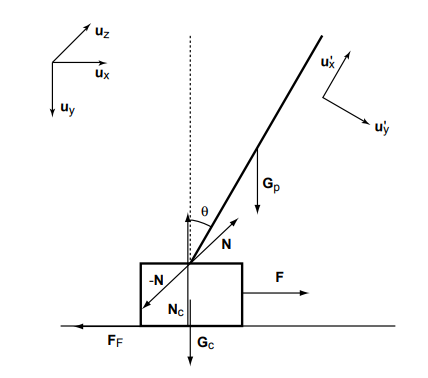

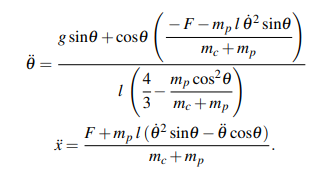

In [9]:
s, c = sym.sin, sym.cos

# dynamics
def f(x, u, constrain=False):

    theta, theta_dot, x_, x_dot = x
    F = sym.tanh(u[0]) if constrain else u[0]

    temp = (F + m * l * theta_dot**2 * s(theta)) / (M + m)
    numerator = g_ * s(theta) - c(theta) * temp
    denominator = l * (4.0 / 3.0 - m * c(theta)**2 / (M + m))
    theta_dot_dot = numerator / denominator

    x_dot_dot = temp - m * l * theta_dot_dot * c(theta) / (M + m)

    return sym.Matrix(
        [
            theta + theta_dot * dt,
            theta_dot + theta_dot_dot * dt,
            x_ + x_dot * dt,
            x_dot + x_dot_dot * dt,
        ]
    )


### Cost

In [4]:
# instantenious cost
def g(x, u, x_goal):
    error = x - x_goal
    return error.T @ Q_i @ error + u.T @ R @ u

In [5]:
# termination cost
def h(x, x_goal):
    error = x - x_goal
    return error.T @ Q_t @ error

### Simulation

In [6]:
# trajectory parameters
N = 3000  # trajectory points
Nx = 4  # state dimension
Nu = 1  # control dimesions

In [7]:
# starting state
x0 = np.array([np.pi, 0.0, 0.0, 0.0])

# goal state we want to reach
x_goal = np.array([0.0, 0.0, 0.0, 0.0])

print("Starting state", x0)
print("Goal state", x_goal)

Starting state [3.14159265 0.         0.         0.        ]
Goal state [0. 0. 0. 0.]


#### iLQR

In [239]:
# Create and run optimizer with random intialization
print("Starting optimization")
start_time = time()
ilqr = DDPOptimizer(Nx, Nu, f, g, h)
X, U, X_hist, U_hist, J_hist = ilqr.optimize(x0, x_goal, N=N, full_output=True)
print("Finished optimization in {:.2f}s".format(time() - start_time))

Starting optimization


Finished optimization in 6.84s


Plotting results


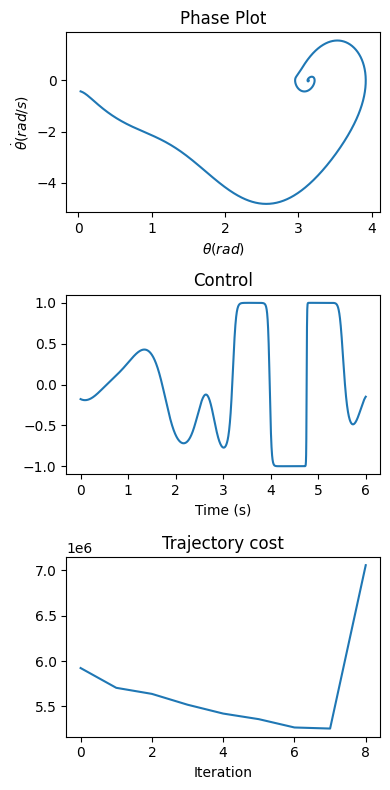

In [240]:
print("Plotting results")
fig, ax = plt.subplots(3, 1, figsize=(4, 8))
tt = np.linspace(0, dt * N, N)
theta_sol = X[:, 0]
theta_dot_sol = X[:, 1]

ax[0].plot(theta_sol, theta_dot_sol)
ax[0].set_xlabel(r"$\theta (rad)$")
ax[0].set_ylabel(r"$\dot{\theta} (rad/s)$")
ax[0].set_title("Phase Plot")
ax[1].set_title("Control")
ax[1].plot(tt, np.tanh(U))
ax[1].set_xlabel("Time (s)")
ax[2].plot(J_hist)
ax[2].set_title("Trajectory cost")
ax[2].set_xlabel("Iteration")
plt.tight_layout()


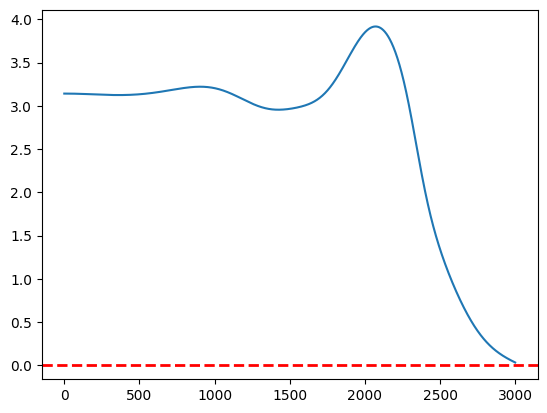

In [241]:
plt.plot(theta_sol)
plt.axhline(y=x_goal[2], xmin=0, xmax=N, linewidth=2, color = 'r', linestyle='--')
plt.show()

#### DDP

In [259]:
# Create and run optimizer with random intialization
print("Starting optimization")
start_time = time()
ddp = DDPOptimizer(Nx, Nu, f, g, h, with_hessians = True)#, alphas = 1.1 ** (-np.arange(10) ** 2), tolerance = 1e-10)
X, U, X_hist, U_hist, J_hist = ddp.optimize(x0, x_goal, N=N, full_output=True)
print("Finished optimization in {:.2f}s".format(time() - start_time))

Starting optimization


<lambdifygenerated-709>:4: RuntimeWarning: overflow encountered in scalar power
  return array([[x0 + 0.002*x1], [x1 + 0.002*(-(0.909090909090909*u0 + 0.0909090909090909*x1**2*sin(x0))*cos(x0) + 9.81*sin(x0))/(1.33333333333333 - 0.0909090909090909*cos(x0)**2)], [x2 + 0.002*x3], [0.00181818181818182*u0 + 0.000181818181818182*x1**2*sin(x0) + x3 - 0.000181818181818182*(-(0.909090909090909*u0 + 0.0909090909090909*x1**2*sin(x0))*cos(x0) + 9.81*sin(x0))*cos(x0)/(1.33333333333333 - 0.0909090909090909*cos(x0)**2)]])
<lambdifygenerated-709>:4: RuntimeWarning: invalid value encountered in scalar add
  return array([[x0 + 0.002*x1], [x1 + 0.002*(-(0.909090909090909*u0 + 0.0909090909090909*x1**2*sin(x0))*cos(x0) + 9.81*sin(x0))/(1.33333333333333 - 0.0909090909090909*cos(x0)**2)], [x2 + 0.002*x3], [0.00181818181818182*u0 + 0.000181818181818182*x1**2*sin(x0) + x3 - 0.000181818181818182*(-(0.909090909090909*u0 + 0.0909090909090909*x1**2*sin(x0))*cos(x0) + 9.81*sin(x0))*cos(x0)/(1.33333333333333 - 0.0

Finished optimization in 4.21s


Plotting results


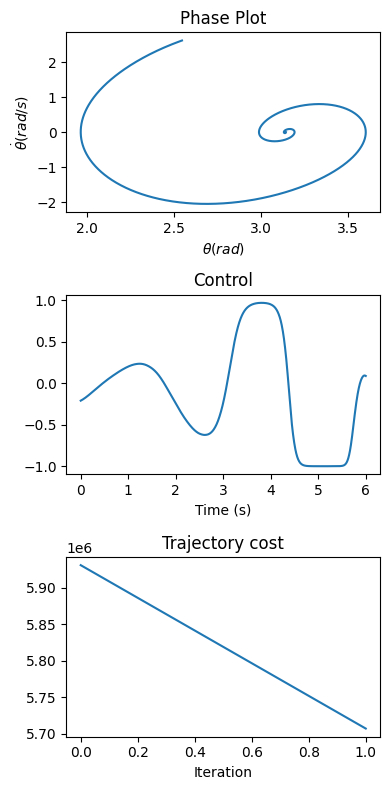

In [260]:
print("Plotting results")
fig, ax = plt.subplots(3, 1, figsize=(4, 8))
tt = np.linspace(0, dt * N, N)
theta_sol = X[:, 0]
theta_dot_sol = X[:, 1]

ax[0].plot(theta_sol, theta_dot_sol)
ax[0].set_xlabel(r"$\theta (rad)$")
ax[0].set_ylabel(r"$\dot{\theta} (rad/s)$")
ax[0].set_title("Phase Plot")
ax[1].set_title("Control")
ax[1].plot(tt, np.tanh(U))
ax[1].set_xlabel("Time (s)")
ax[2].plot(J_hist)
ax[2].set_title("Trajectory cost")
ax[2].set_xlabel("Iteration")
plt.tight_layout()

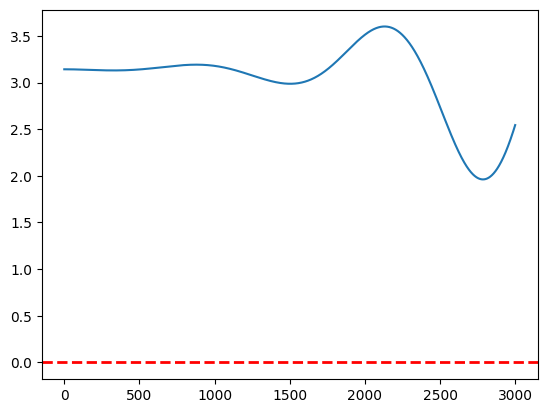

In [261]:
plt.plot(theta_sol)
plt.axhline(y=x_goal[2], xmin=0, xmax=N, linewidth=2, color = 'r', linestyle='--')
plt.show()

#### LQR

In [10]:
# Create and run optimizer with random intialization
print("Starting optimization")
start_time = time()
lqr = LQROPtimizer(Nx, Nu, f, g, h)
X, U, X_hist, U_hist, J_hist = lqr.optimize(x0, x_goal, N=N, full_output=True)
print("Finished optimization in {:.2f}s".format(time() - start_time))

Starting optimization
Finished optimization in 1.33s


Plotting results


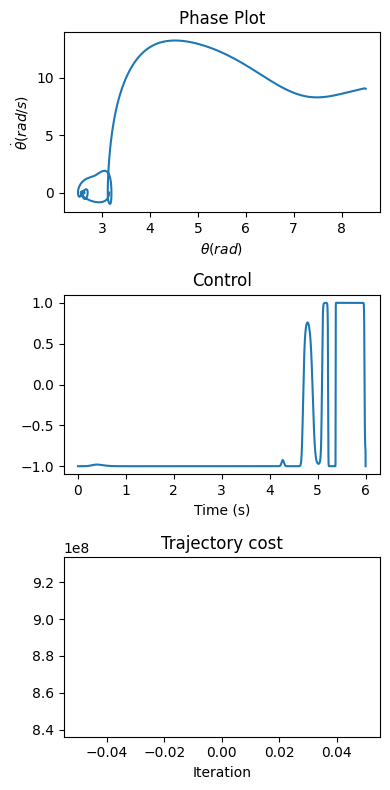

In [11]:
print("Plotting results")
fig, ax = plt.subplots(3, 1, figsize=(4, 8))
tt = np.linspace(0, dt * N, N)
theta_sol = X[:, 0]
theta_dot_sol = X[:, 1]

ax[0].plot(theta_sol, theta_dot_sol)
ax[0].set_xlabel(r"$\theta (rad)$")
ax[0].set_ylabel(r"$\dot{\theta} (rad/s)$")
ax[0].set_title("Phase Plot")
ax[1].set_title("Control")
ax[1].plot(tt, np.tanh(U))
ax[1].set_xlabel("Time (s)")
ax[2].plot(J_hist)
ax[2].set_title("Trajectory cost")
ax[2].set_xlabel("Iteration")
plt.tight_layout()


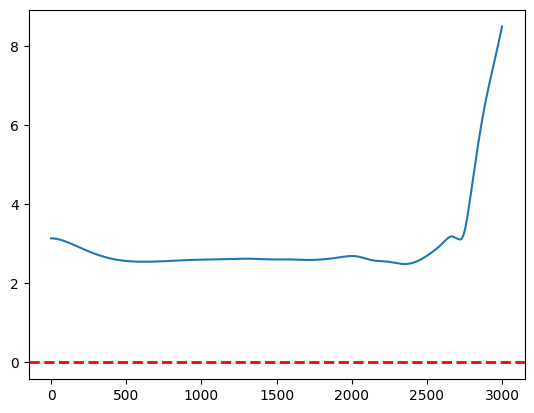

In [12]:
plt.plot(theta_sol)
plt.axhline(y=x_goal[2], xmin=0, xmax=N, linewidth=2, color = 'r', linestyle='--')
plt.show()